In [ ]:
! pip install easyocr
! pip install git+https://github.com/facebookresearch/segment-anything.git
! pip install opencv-python matplotlib
! pip install wget
! pip install onnxruntime onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-46bo_cj1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-46bo_cj1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wget

#url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth' # vit_h link, but there's no much difference apparently in the solution
url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth'
filename = wget.download(url)

In [1]:
import os
import glob

import imutils
import shutil
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
import torch
from PIL import Image

%matplotlib inline
is_gpu = True if torch.cuda.is_available() else False
reader = easyocr.Reader(['pl'], gpu=is_gpu)


Using CPU. Note: This module is much faster with a GPU.


In [2]:
path_books = "./books/"
path_output = "./output/"
if os.path.exists(path_books)==False:
    os.mkdir(path_books)
if os.path.exists(path_output)==False:
    os.mkdir(path_output)
else:
    for filename in os.listdir(path_output):
        file_path = os.path.join(path_output, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [3]:
def list_image_paths(folder_path):
    # Create a list of all files with the extensions ".jpg" and ".png"
    files = glob.glob(os.path.join(folder_path, "*.jpg")) + glob.glob(os.path.join(folder_path, "*.png"))
    print(f"Number of files: {len(files)}")

    return files

In [4]:
# add files you want to process to "books" folder
img_paths = list_image_paths("./books/")

Number of files: 1


# Books segmentation - SAM + Non Maximum Suppresion

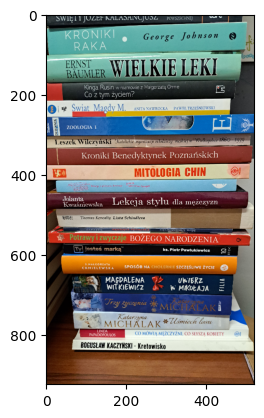

In [5]:
image_path = img_paths[0]
img = cv2.imread(img_paths[0])
#img = cv2.resize(img, (400, 250))
img = cv2.resize(img, (0, 0), fx = 0.2, fy = 0.2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [6]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

In [7]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
ckp_path = "sam_vit_l_0b3195.pth"
sam = sam_model_registry["vit_l"](checkpoint=ckp_path)
# move SAM to gpu sam.to("")
mask_generator = SamAutomaticMaskGenerator(sam)


In [8]:
masks = mask_generator.generate(img) # on cpu - +/- 8min one image

In [9]:
print(len(masks))
print(masks[0])

118
{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 21845, 'bbox': [0, 329, 512, 48], 'predicted_iou': 1.0299601554870605, 'point_coords': [[333.765625, 332.421875]], 'stability_score': 0.9707530736923218, 'crop_box': [0, 0, 521, 925]}


In [10]:
def nms(detections, threshold):
    """
    Applies Non-Maximum Suppression to an array of detections

    :param detections: a numpy array of shape (N, 5), where each row contains 
                       (x1, y1, x2, y2, score) representing a detection
    :param threshold: the IoU threshold to use for overlapping detections
    :return: a list of indices representing the detections to keep after NMS
    """
    x1 = detections[:, 0]
    y1 = detections[:, 1]
    x2 = detections[:, 2]
    y2 = detections[:, 3]
    scores = detections[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = np.argsort(scores)[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)

        overlap = (w * h) / areas[order[1:]]

        inds = np.where(overlap <= threshold)[0]
        order = order[inds + 1]

    return keep

In [11]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from skimage import measure


# Extract the confidence scores from the generated masks
scores = [mask["stability_score"] for mask in masks]

# Define the confidence threshold for the masks
confidence_threshold = 0.5

# Convert the generated masks to binary images
binary_masks = [(mask["segmentation"] > confidence_threshold).astype(int) for mask in masks]

# Get the contours and bounding boxes for each binary mask
regions = []
for binary_mask in binary_masks:
    label_image = measure.label(binary_mask)
    region_props = measure.regionprops(label_image)
    regions.append(region_props[0])
boxes = [region.bbox for region in regions]

# Create a list of detections with the bounding boxes and corresponding confidence scores
detections = np.hstack((np.array(boxes), np.array(scores)[:, np.newaxis]))

# Perform non-maximum suppression on the detections
nms_threshold = 0.5
keep = nms(detections, nms_threshold)

# Keep only the detections that were not suppressed
if len(keep) > 0:
    detections = detections[keep]
else:
    detections = []

# Keep only the boxes and scores that were not suppressed
boxes = [boxes[i] for i in keep]
scores = [scores[i] for i in keep]

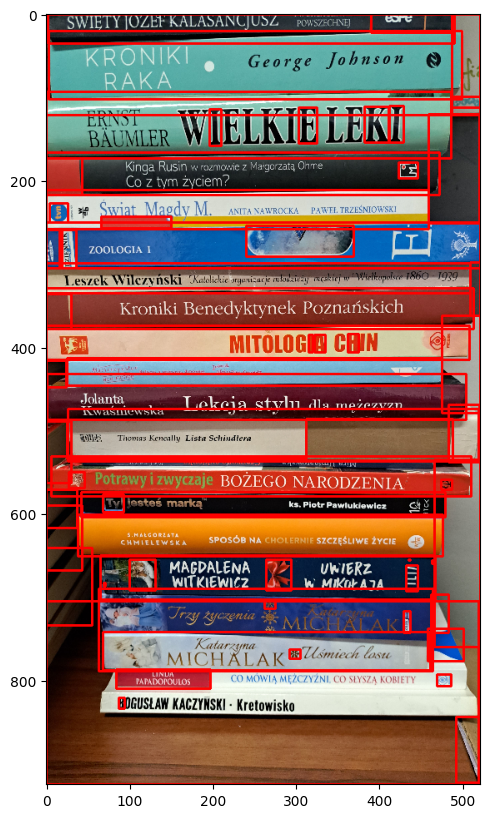

In [12]:
# Create a copy of the original image to draw the detections on
img_copy = img.copy()

# Draw the detections as bounding boxes on the image
for box in boxes:
    cv2.rectangle(img_copy, (box[1], box[0]), (box[3], box[2]), (255, 0, 0), 2)
    
# Show the image with the detections
plt.figure(figsize=(10, 10))
plt.imshow(img_copy)
plt.show()

In [13]:
# If one dimention of the box is bigger than another at least 3 times tha another one, then it is a book page and we keep it, otherwise we discard it. 
# If the area of the box is smallet than 1/50 of the image, we discard it as well.
# Create a list of boxes that are likely to be book pages

img_copy = img.copy()
book_page_boxes = []
for box in boxes:
    if (box[2] - box[0]) > 3.5 * (box[3] - box[1]) and (box[2] - box[0]) * (box[3] - box[1]) > (img.shape[0] * img.shape[1]) / 50:
        book_page_boxes.append(box)
    elif (box[3] - box[1]) > 3.5 * (box[2] - box[0]) and (box[2] - box[0]) * (box[3] - box[1]) > (img.shape[0] * img.shape[1]) / 50:
        book_page_boxes.append(box)
    else:
        continue

print(len(book_page_boxes))
print(book_page_boxes)

21
[(0, 2, 35, 490), (374, 0, 415, 508), (413, 25, 446, 475), (20, 3, 102, 499), (166, 0, 217, 472), (487, 25, 534, 312), (742, 68, 788, 461), (574, 42, 604, 479), (601, 38, 651, 476), (690, 63, 789, 464), (329, 0, 378, 513), (474, 26, 537, 519), (211, 0, 258, 459), (250, 0, 305, 521), (299, 0, 335, 509), (432, 1, 487, 504), (93, 0, 173, 486), (121, 0, 250, 520), (650, 65, 703, 467), (535, 466, 760, 521), (531, 6, 579, 510)]


In [34]:
# put the boxes on the image of original size (from image_path) and make sure the book_page_boxes coordinates are resized from the resized image to the original image
# Show the image with the detections
resized_img = img.copy()
img_original = cv2.imread(image_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img_original_copy = img_original.copy()

scale_1 = img_original.shape[0] / resized_img.shape[0]
scale_2 = img_original.shape[1] / resized_img.shape[1]

#crop the book pages from the original image and save to output folder with name of original file name and index
for i, box in enumerate(book_page_boxes):
    box = [int(box[0] * scale_1), int(box[1] * scale_2), int(box[2] * scale_1), int(box[3] * scale_2)]
    #img_original = cv2.rectangle(img_original_copy, (box[1], box[0]), (box[3], box[2]), (255, 0, 0), 2)
    crop_img = img_original[box[0]:box[2], box[1]:box[3]]
    cv2.imwrite(os.path.join(path_output, os.path.basename(image_path).split(".")[0] + "_" + str(i) + ".jpg"), crop_img)
          
#plt.figure(figsize=(10, 10))
#plt.imshow(img_original)


### Image preprocessing

In [26]:
def correct_rotation_tryout(img_path):
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    if h > w:
        new_img = imutils.rotate_bound(img, -90)
    else:
        new_img = img

    cv2.imwrite(img_path, new_img)

In [35]:
def image_smoothening(img):
    ret1, th1 = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

def img_preprocess(file_name):
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 3)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    ocr_image = image_smoothening(img)
    ocr_image = cv2.bitwise_or(img, closing)
    
    #make image to white and black
    ocr_image = cv2.threshold(ocr_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # if there are white letters with black countour, make them black and countour white
    ocr_image = cv2.bitwise_not(ocr_image)

    cv2.imwrite(file_name, ocr_image)

In [31]:
def check_upside_down(img_path):
    img = cv2.imread(img_path)
    org_img_text = reader.readtext(img)
    rotated_img = imutils.rotate_bound(img, 180)
    rotated_img_txt = reader.readtext(rotated_img)
    count_original = sum(len(element[-2])*element[-1] for element in org_img_text)
    count_rotated = sum(len(element[-2])*element[-1] for element in rotated_img_txt)


    if count_original < count_rotated:
        cv2.imwrite(img_path, rotated_img)

In [36]:
img_paths_cropped = list_image_paths("./output/")
for img_path in img_paths_cropped:
    img_preprocess(img_path)
    check_upside_down(img_path)


Number of files: 21


# Try easyOCR

In [22]:
def recognize_text(img_path):
    return reader.readtext(img_path)

In [38]:
def overlay_ocr_text(img_path):
    '''loads an image, recognizes text, and overlays the text on the image.'''
    # loads image
    img = cv2.imread(img_path)
    result = recognize_text(img_path)
    text_all = [img_path]

    not_recognized = 0
    # if OCR prob is over 0.5, overlay bounding box and text
    for (bbox, text, prob) in result:
        if prob >= 0.5:
            text_all.append(text)
            #print(f'Detected text: {text} (Probability: {prob:.2f})')
            
        if len(text_all)==1:
            not_recognized = 1

    if not_recognized == 1:
        #reverse image
        img = cv2.bitwise_not(img)
        cv2.imwrite(img_path, img)
        result = recognize_text(img_path)
        for (bbox, text, prob) in result:
            if prob >= 0.5:
                text_all.append(text)
        
    if len(text_all)==1:
        text_all.append("NIE_ROZPOZNANO_TYTUŁU")
        return text_all
    
    return text_all


In [39]:
with open("text.txt", "w") as txt_file:
    for im_path in img_paths_cropped:
        text = overlay_ocr_text(im_path)
        text_str = ' '.join(text)
        txt_file.write(text_str)
        txt_file.write("\n")

# Web scrapping for the title/author

In [41]:
! pip install requests_html
! pip install pandas
import requests
import urllib
import pandas as pd
from requests_html import HTML
from requests_html import HTMLSession

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 20.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 33.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib


In [42]:
def get_source(url):
    #Return the source code for the provided URL.
    try:
        session = HTMLSession()
        response = session.get(url)
        return response

    except requests.exceptions.RequestException as e:
        print(e)

In [43]:
def get_results(query):
    
    query = urllib.parse.quote_plus(query)
    response = get_source("https://www.google.pl/search?q=" + query)
    
    return response

In [44]:
def parse_results(response):
    
    css_identifier_result = ".tF2Cxc"
    css_identifier_title = "h3"
    css_identifier_link = ".yuRUbf a"
    css_identifier_text = ".VwiC3b"
    
    results = response.html.find(css_identifier_result)

    output = []
    
    for result in results:

        item = {
            'title': result.find(css_identifier_title, first=True).text,
            'link': result.find(css_identifier_link, first=True).attrs['href']
        }
        
        output.append(item)
        
    return output

In [45]:
def google_search(query):
    response = get_results(query)
    return parse_results(response)

In [46]:
with open('text.txt') as f:
    all_books = f.readlines()

img_path = []
queries = []
for i in range(len(all_books)): 
    book = all_books[i].split(" ", 1)
    #WHY IT DOES NOT WORK???
    book[1].rstrip('\n') 
    img_path.append(book[0])
    queries.append(book[1])

In [48]:
google_search(queries[0])

[{'title': 'Mitologia chińska – Wikipedia, wolna encyklopedia',
  'link': 'https://pl.wikipedia.org/wiki/Mitologia_chi%C5%84ska'},
 {'title': 'Chińska mitologia - - Mity i legendy',
  'link': 'https://mityczne.pl/category/chinska-mitologia/'},
 {'title': 'Analiza genezy mitu zła w kulturze chińskiej - Anthropos',
  'link': 'https://www.anthropos.us.edu.pl/anthropos7/texty/konior.htm'},
 {'title': 'Mitologia Chin - Derek Walters | książka w tezeusz.pl książki ...',
  'link': 'https://tezeusz.pl/mitologia-chin-walters-derek-4421449'},
 {'title': 'Mitologia chińska - Szkolnictwo.pl',
  'link': 'https://szkolnictwo.pl/szukaj,Mitologia_chi%C5%84ska'},
 {'title': 'Społeczno-religijne uwarunkowania wczesnej kultury chińskiej',
  'link': 'https://cejsh.icm.edu.pl/cejsh/element/bwmeta1.element.desklight-71e97b18-bca7-4949-9432-bd9477108ed2/c/tom_12_1_7_karol_kierzkowski_spoleczno_religijne_uwarunkowania_wczesnej_kultury_chinskiej.pdf'},
 {'title': 'Mitologia chińska - Mieczysław Jerzy Kunstler 